In [1]:
import os
import sys
import ztffields
import numpy as np
import pandas as pd
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from typing import Iterable, Tuple
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import simple_norm
from astropy.table import Table, vstack
from astropy.io import ascii, fits
from astropy.nddata import NDData
from astropy.table import Table
from photutils.psf import extract_stars, EPSFBuilder, EPSFStars, EPSFFitter, PSFPhotometry

sys.path.append('/Users/adamboesky/Research/long_transients/Source_Analysis')
sys.path.append('/Users/adamboesky/Research/long_transients/Extracting')
sys.path.append('/Users/adamboesky/Research/long_transients')

from filter_fields import combine_stats, create_filter_flowchart
from Extracting.utils import get_n_quadrants_merged_all_fields, load_ecsv, img_ab_mag_to_flux
from Extracting.Catalogs import get_ztf_metadata_from_coords, ztf_image_exists, get_ztf_metadata_from_metadata
from Source_Analysis.Sources import Sources, Source

# Plot formatting
plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed
mpl.rcParams['axes.formatter.use_mathtext'] = True

/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CasJobs will use the credentials from mast_login_harvard.txt
CasJobs will use the credentials from mast_login_harvard.txt


# Extraction Info Plot

In [2]:
from Extracting.Catalogs import ZTF_Catalog

ztf_cat = ZTF_Catalog(
    ra=None,
    dec=None,
    band='g',
    image_metadata={
        'fieldid': 582,
        'ccdid': 1,
        'qid': 1,
    }
)

Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmptlr1woo0/ztf_000582_zg_c01_q1_refimg.fits


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


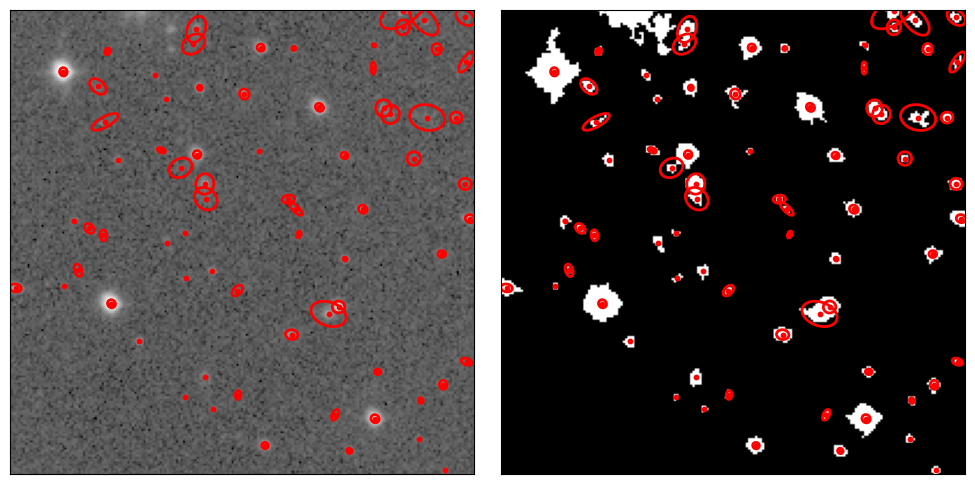

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ztf_cat.sextractor.plot_segmap(image_is_subtracted=True, show_source_shapes=True, s=10, ax=axes[0])
ztf_cat.sextractor.plot_segmap(image_is_subtracted=False, show_source_shapes=True, s=10, ax=axes[1])

for ax in axes:
    # Make it a cutout
    ax.set_xlim((400, 600))
    ax.set_ylim((400, 600))

    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/long_transients/Figures/segmap.pdf', bbox_inches='tight')
plt.show()

# PSF Subtracted

In [112]:
from Extracting.Tile import Tile
tile = Tile(
    ra=None,
    dec=None,
    bands=['g'],
    ztf_metadata={
        'fieldid': 582,
        'ccdid': 1,
        'qid': 1,
    },
)
tile.data_dicts

Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmpazqz3wol/ztf_000582_zg_c01_q1_refimg.fits
g_pstarr_sources_ra233p68_234p63_dec16p029_16p936 not in MyDB, submitting request to make it!
Submitted query for g_pstarr_sources_ra233p68_234p63_dec16p029_16p936 with id=115239803
Retrieving g_pstarr_sources_ra233p68_234p63_dec16p029_16p936 from MyDB!
Extracting sources...
Calculating Kron magnitudes...
Calculating PSF magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
/Users/adamboesky/Research/long_transients/Extracting/utils.py:45: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)


Info for g EPSF fitting in coordinate range ((233.68362991230057, 234.63029088493406), (16.029024001080654, 16.936747866585403)):
	Number of sources: 15742
	Number of sources with NaN nearby: 254
	Number of sources with truncated: 8
	Number of sources with NaN init flux: 0
Fitting PSF model using 282 stars...


EPSFBuilder (10 maxiters): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


TableMergeError: The 'PSTARR_primaryDetection' columns have incompatible types: ['object', 'float64', 'object']

In [120]:
resid = tile.ztf_catalogs['g'].sextractor.psfphot.make_residual_image(tile.ztf_catalogs['g'].sextractor.image_sub)

In [ ]:
# Load the image and the epsf
img = fits.open('/Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000202_zg_c10_q1_refimg.fits')[0].data
epsf = np.load('/Users/adamboesky/Research/long_transients/Data/test/000202_10_1/EPSFs/ZTF_g_EPSF.npy')
g_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000202_g.ecsv')

In [138]:
# Filter for our field of interest
g_tab = g_tab[(g_tab['fieldid'] == '000202') & (g_tab['ccdid'] == '10') & (g_tab['qid'] == '1')]
g_tab.sort('ZTF_gPSFMag')
g_tab

ra,dec,ZTF_thresh,ZTF_npix,ZTF_tnpix,ZTF_xmin,ZTF_xmax,ZTF_ymin,ZTF_ymax,ZTF_x,ZTF_y,ZTF_x2,ZTF_y2,ZTF_xy,ZTF_errx2,ZTF_erry2,ZTF_errxy,ZTF_a,ZTF_b,ZTF_theta,ZTF_cxx,ZTF_cyy,ZTF_cxy,ZTF_cflux,ZTF_flux,ZTF_cpeak,ZTF_peak,ZTF_xcpeak,ZTF_ycpeak,ZTF_xpeak,ZTF_ypeak,ZTF_sepExtractionFlag,ZTF_KronRad,ZTF_gKronMag,ZTF_gKronMagErr,ZTF_gKronCircleFlag,ZTF_gKronFlag,ZTF_gPSFMag,ZTF_gPSFMagErr,ZTF_gPSFFlags,ZTF_qfit,ZTF_cfit,ZTF_g_zero_pt_mag,ZTF_g_mag_limit,ZTF_ra,ZTF_dec,PSTARR_PanSTARR_ID,PSTARR_gKronMag,PSTARR_gKronMagErr,PSTARR_gApMag,PSTARR_gApMagErr,PSTARR_gPSFMag,PSTARR_gPSFMagErr,PSTARR_gpsfLikelihood,PSTARR_ginfoFlag2,PSTARR_rKronMag,PSTARR_rKronMagErr,PSTARR_rApMag,PSTARR_rApMagErr,PSTARR_rPSFMag,PSTARR_rPSFMagErr,PSTARR_rpsfLikelihood,PSTARR_rinfoFlag2,PSTARR_ra,PSTARR_dec,association_separation_arcsec,Catalog,Catalog_Flag,x,y,fieldid,ccdid,qid
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,int64,float64,float64,str6,str2,str1
25.01236741195368,-29.7978518309042,1.506439447402954,1095.0,998.0,145.0,189.0,738.0,787.0,169.2532982620537,764.4252321893243,3.5390684446578007,3.7732303495349697,-0.0006530207518835,6.262471160422425e-07,7.207499725112236e-07,3.39699474188061e-08,1.9424809217453003,1.881240725517273,-1.5680075883865356,0.2825602293014526,0.2650249004364013,9.78035677690059e-05,600202.25,600335.375,40171.1484375,55249.3203125,169.0,764.0,169.0,764.0,0.0,0.9929777396371048,11.929640471589812,7.661683196650514e-05,0.0,0.0,11.891373428961634,1.4014848343337885e-05,0.0,0.017877809419005,-0.0022495217691197,26.325,22.74,25.01236741195368,-29.7978518309042,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,ZTF,1,169.2532982620537,764.4252321893243,000202,10,1
25.761161294782084,-29.850606490189342,1.506439447402954,1106.0,997.0,2477.0,2527.0,967.0,1011.0,2504.8648182435813,990.0730311315856,3.6288491144628097,3.782769946239455,-0.0066426562763126,7.133384928038606e-07,6.923326276137471e-07,5.330656186440404e-08,1.9450080394744875,1.9048787355422967,-1.5277466773986816,0.2755703628063202,0.2643573880195617,0.0009678194182924,593157.8125,593282.1875,40393.6953125,55230.9375,2505.0,990.0,2505.0,990.0,0.0,0.9874797715303586,11.942761614371012,7.714230191946884e-05,0.0,0.0,11.913376307005784,1.3717561928019243e-05,0.0,0.0199379629259689,-0.0026742038057124,26.325,22.74,25.761192968728068,-29.85066544508099,7.217025761102963e+16,14.1483001708984,0.0009590000263415,13.8450002670288,0.0500000007450581,13.8242998123169,0.0500000007450581,--,4224.0,11.7531995773315,0.0004710000066552,11.7926998138428,0.0001029999984893,12.7683000564575,0.0009500000160187,2.3608600330050403e-31,524440.0,25.7611296208361,-29.8505475352977,0.4682973411164526,Both,0,2504.8648182435813,990.0730311315856,000202,10,1
25.56922213175736,-30.334121837881973,1.506439447402954,944.0,851.0,1858.0,1898.0,2699.0,2747.0,1876.3354203440745,2719.728491084719,3.3042405502427528,3.835536766091764,-0.0045373612004482,4.585386070034119e-07,8.068984210925158e-07,1.6083861118047368e-08,1.958462595939636,1.8177464008331297,-1.562256932258606,0.302641898393631,0.2607201337814331,0.000716038281098,565536.1875,565633.25,37008.82421875,49849.1953125,1876.0,2720.0,1876.0,2720.0,1.0,1.0114129545194568,11.991341535328544,7.91016567615953e-05,0.0,0.0,11.939963082299908,1.500513324024718e-05,0.0,0.0117695498097329,-0.0002173240635971,26.325,22.74,25.56922213175736,-30.334121837881973,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,ZTF,3,1876.3354203440745,2719.728491084719,000202,10,1
2

In [155]:
# Get the coordinates of the first source in the table
x, y, flux_init = g_tab[['ZTF_x', 'ZTF_y', 'ZTF_gPSFMag']][113]
x, y = int(x), int(y)
x, y

(166, 1299)

In [208]:
tile.ztf_catalogs['g'].data.sort('gPSFMag')
x, y = tile.ztf_catalogs['g'].data[['x', 'y']][810]

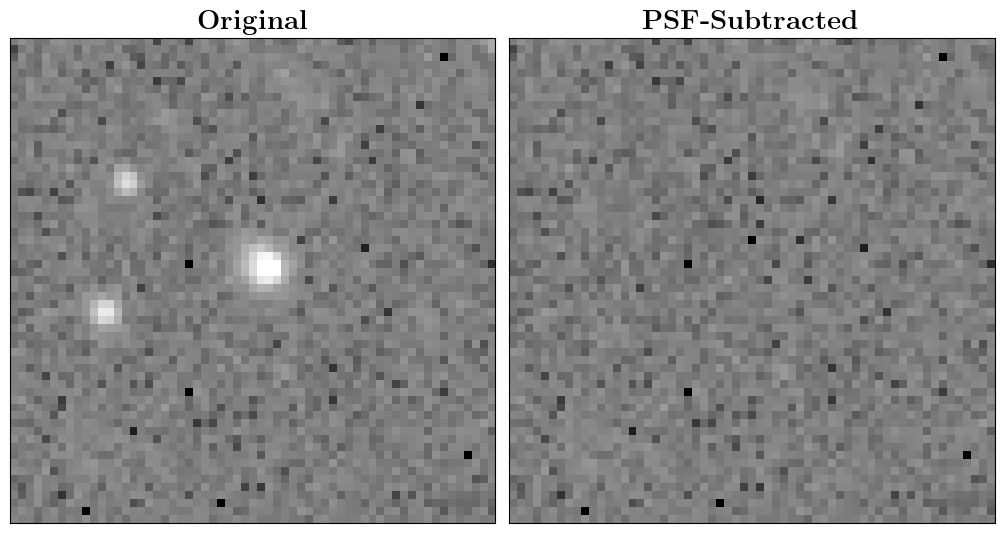

In [217]:
# Display the original and subtracted images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

halfwidth = 30

cutout = tile.ztf_catalogs['g'].sextractor.image_sub[int(y) - halfwidth - 1 : int(y) + halfwidth, int(x) - halfwidth - 1 : int(x) + halfwidth]
epsf_subtracted_cutout = resid[int(y) - halfwidth - 1 : int(y) + halfwidth, int(x) - halfwidth - 1 : int(x) + halfwidth]

norm = simple_norm(cutout, 'log', percent=99.75)

axes[0].imshow(cutout, origin='lower', cmap='gray', norm=norm)
axes[0].set_title(r"\textbf{Original}", fontsize=20)

axes[1].imshow(epsf_subtracted_cutout, origin='lower', cmap='gray', norm=norm)
axes[1].set_title(r"\textbf{PSF-Subtracted}", fontsize=20)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout(pad=0.1)
plt.savefig('/Users/adamboesky/Research/long_transients/Figures/psf_subtracted_cutout.pdf', bbox_inches='tight')

plt.show()

# Filter Source Examples

In [245]:
from Source_Analysis.filter_fields import *

# Load in the tables
field_name = '000582'
tables = {}
bands = ('g')
for band in bands:
    try:
        tables[band] = load_ecsv(os.path.join(get_data_path(), f'catalog_results/field_results/{field_name}_{band}.ecsv'))
    except FileNotFoundError:
        print(f'Warning: Band {band} not available for field {field_name}...')

# Set values <=0 to the upper limit for ZTF
for band in tables.keys():
    tab: Table = tables[band]
    upper_lim_mask = tab[f'ZTF_{band}PSFFlags'] == 4
    tab[f'ZTF_{band}PSFMag'][upper_lim_mask] = tab[f'ZTF_{band}_mag_limit'][upper_lim_mask]   # 4 means flux was negative
    tab[f'ZTF_{band}_upper_lim_flag'] = False
    tab[f'ZTF_{band}_upper_lim_flag'][upper_lim_mask] = True
    tables[band] = remove_mask(tab)

## SEP Flags

In [246]:
def _is_flag(flags: np.ndarray, flag: int) -> np.ndarray:
    return np.bitwise_and(flags.astype(int), [flag for _ in range(len(flags))]) != 0

sep_bad_tabs = tables.copy()
sep_bad_tabs = {b: t[t['Catalog_Flag'] == 0] for b, t in sep_bad_tabs.items()}
for band in tables.keys():
    tab = tables[band]
    bad_flags = [8, 16, 32, 64, 128]
    mask = np.logical_or(tab[f'ZTF_sepExtractionFlag'] != 0, np.isnan(tab[f'ZTF_sepExtractionFlag']))
    for f in bad_flags:
        mask = np.logical_or(mask, _is_flag(tab[f'ZTF_sepExtractionFlag'], f))
    sep_bad_tabs[band] = tab[mask]

/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20745/1028511428.py:2: RuntimeWarning: invalid value encountered in cast
  return np.bitwise_and(flags.astype(int), [flag for _ in range(len(flags))]) != 0


In [247]:
inds = np.random.randint(0, len(sep_bad_tabs['g']), 1000)
bad_srcs = Sources(
    ras=sep_bad_tabs['g']['ra'][inds],
    decs=sep_bad_tabs['g']['dec'][inds],
    field_catalogs=sep_bad_tabs,
)

Searching for source in the catalogs!
Searching g catalog for source...
Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=field=000582+AND+ccdid=02+AND+qid=1
Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmpj2ipri7l/ztf_000582_zg_c02_q1_refimg.fits
Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmp7opb2rmk/ztf_000582_zr_c02_q1_refimg.fits
Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmpim0sfhcz/ztf_000582_zi_c02_q1_refimg.fits
Searching for source in the catalogs!
Searching g catalog for source...
Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=field=000582+AND+ccdid=09+AND+qid=1

Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmp3xhzyk3a/ztf_000582_zr_c09_q1_refimg.fits
Image downloaded and saved at /var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/tmplvb1jol0/ztf_000582_zg_c09_q1

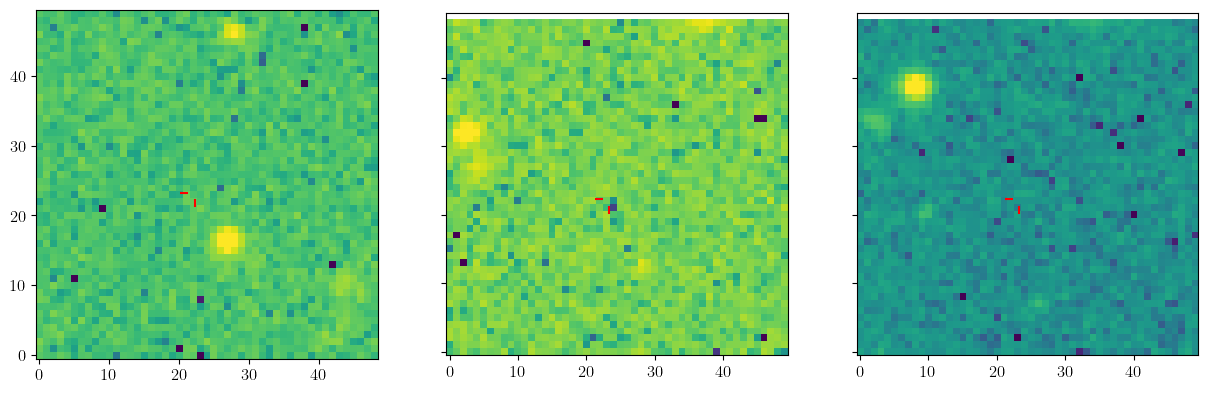

In [248]:
init_ind = 100
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for src, ax in zip(bad_srcs[init_ind:init_ind+3], axes):
    src.postage_stamps['ZTF'].plot_cutout(band='g', ax=ax)

# Plotting candidates next to ANTs from Wiseman et al. 2024

In [16]:
from astropy.cosmology import FlatLambdaCDM
from Source_Analysis.Sources import Source
from Source_Analysis.Light_Curve import Light_Curve
from astropy.table import MaskedColumn

In [17]:
# First, save off info about each of the ANTs
# Define the data as a dictionary from https://arxiv.org/pdf/2406.11552
data = {
    "ZTF ID": [
        "ZTF20abrbeie", "ZTF19aamrjar", "ZTF20abodaps", "ZTF18aczpgwm", "ZTF21abxowzx",
        "ZTF19aailpwl", "ZTF20abgxlut", "ZTF20aadesap", "ZTF18acvvudh", "ZTF22aaaeons",
        "ZTF20acvfraq", "ZTF19aatubsj", "ZTF20aanxcpf"
    ],
    "RA": [
        318.45173, 272.33963, 359.80815, 33.79096, 324.33304,
        216.94340, 257.76525, 232.76545, 117.7084916, 231.827862,
        349.72403, 257.27857, 15.16508
    ],
    "Dec": [
        27.43066, 25.30919, -17.69658, 7.16453, -10.753312,
        29.51061, 6.736331, 53.40535, 1.358392278, -8.532609,
        -10.58489, 26.85569, 39.70842
    ],
    "IAU name": [
        "AT2021lwx", "-", "AT2020afep", "AT2019kn", "AT2021yzu",
        "AT2019brs", "AT2020oio", "AT2022fpx", "AT2018lcp", "AT2022zg",
        "AT2020adpi", "AT2019fdr", "AT2021loi"
    ],
    "Crossmatches": [
        "ATLAS20bkdj, PS22iin", "ATLAS19mmu", "ATLAS20vrw", "ATLAS19bdfo, Gaia19abv", "ATLAS21bjoi",
        "ATLAS19fyh, Gaia19axp", "Gaia20dvv, ATLAS20rmk", "ATLAS22kjn, Gaia22cwy, PS23bdt", "-", "Gaia22aft, ATLAS22ery",
        "ATLAS20bjzp, Gaia21aid", "ATLAS19lkd", "ATLAS21qje"
    ],
    "r-mag": [
        0.9945, 18.3, 19.8, 19.1, 20.3,
        19.3, 20.4, 17.9, 18.6, 18.5,
        19.7, 18, 18
    ],
    "redshift": [
        0.9945, 0.697, 0.607, 0.4279, 0.419,
        0.3736, 0.247, 0.073, np.nan, np.nan,
        0.26, 0.2666, 0.083
    ]
}

# Create a DataFrame
ant_df = pd.DataFrame(data)

# Save to a CSV file
csv_filename = "/Users/adamboesky/Research/long_transients/ANTs-Nest/ant_properties.csv"
ant_df.to_csv(csv_filename, index=False)

ant_df

,ZTF ID,RA,Dec,IAU name,Crossmatches,r-mag,redshift
0,ZTF20abrbeie,318.451730,27.430660,AT2021lwx,"ATLAS20bkdj, PS22iin",0.9945,0.9945
1,ZTF19aamrjar,272.339630,25.309190,-,ATLAS19mmu,18.3000,0.6970
2,ZTF20abodaps,359.808150,-17.696580,AT2020afep,ATLAS20vrw,19.8000,0.6070
3,ZTF18aczpgwm,33.790960,7.164530,AT2019kn,"ATLAS19bdfo, Gaia19abv",19.1000,0.4279
4,ZTF21abxowzx,324.333040,-10.753312,AT2021yzu,ATLAS21bjoi,20.3000,0.4190
5,ZTF19aailpwl,216.943400,29.510610,AT2019brs,"ATLAS19fyh, Gaia19axp",19.3000,0.3736
6,ZTF20abgxlut,257.765250,6.736331,AT2020oio,"Gaia20dvv, ATLAS20rmk",20.4000,0.2470
7,ZTF20aadesap,232.765450,53.405350,AT2022fpx,"ATLAS22kjn, Gaia22cwy, PS23bdt",17.9000,0.0730
8,ZTF18acvvudh,117.708492,1.358392,AT2018lcp,-,18.6000,NaN
9,ZTF22aaaeons,231.827862,-8.532609,AT2022zg,"Gaia22aft, ATLAS22ery",18.5000,NaN


In [18]:
lightcurves = {}
base_path = '/Users/adamboesky/Research/long_transients/ANTs-Nest/lightcurves'

for ztf_id in ant_df['ZTF ID']:
    filename = f'{ztf_id}_lc.dat'
    filepath = os.path.join(base_path, filename)
    if os.path.exists(filepath):
        lightcurves[ztf_id] = pd.read_csv(filepath, delimiter=" ") # Adjust delimiter as needed
        lightcurves[ztf_id] = lightcurves[ztf_id][lightcurves[ztf_id]['band'].str.contains('ZTF')] # mask for just ZTF
    else:
        print(f'Warning: Light curve file {filename} not found.')

lightcurves

{'ZTF20abrbeie':               MJD        mag    magerr   band
 41   59073.871065  20.530400  0.146362  ZTF_g
 42   59075.837870  20.699044  0.142772  ZTF_g
 43   59075.889861  20.579917  0.141991  ZTF_g
 44   59077.853484  20.654973  0.147280  ZTF_g
 45   59078.864063  20.459350  0.110584  ZTF_g
 ..            ...        ...       ...    ...
 648  60528.904306  20.561857  0.139501  ZTF_r
 649  60530.818368  20.491137  0.123456  ZTF_r
 650  60532.822454  20.773928  0.117717  ZTF_r
 651  60533.821007  20.696212  0.122618  ZTF_r
 652  60534.801632  20.630304  0.108040  ZTF_r
 
 [612 rows x 4 columns],
 'ZTF19aamrjar':                MJD        mag    magerr   band
 325   58559.000336  20.387568  0.146353  ZTF_g
 326   58573.966852  20.123652  0.123277  ZTF_g
 327   58573.967766  20.229367  0.129459  ZTF_g
 328   58581.969086  19.907331  0.096726  ZTF_g
 329   58582.998299  19.952379  0.076965  ZTF_g
 ...            ...        ...       ...    ...
 1396  60143.889768  18.771555  0.033661 

In [19]:
def get_absolute_lc(time: np.ndarray, mags: np.ndarray, redshift: float, k_correct: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    if not isinstance(time, np.ndarray):
        time = np.array(time)
    if not isinstance(mags, np.ndarray):
        mags = np.array(mags)

    # Get luminosity distance
    d = FlatLambdaCDM(H0=70, Om0=0.3).luminosity_distance(redshift).to('pc').value
    k_corr = -2.5 * np.log10(1 + redshift) if k_correct else 0

    # Convert to time and absolute magnitude
    abs_mag = mags - 5 * (np.log10(d) - 1) - k_corr
    if mags.ndim == 1:
        peak_time = time[np.nanargmin(abs_mag)]
    else:
        peak_time = time[np.nanargmin(np.nanmin(abs_mag, axis=1))]
    rest_time = (time - peak_time) / (1 + redshift)

    return rest_time, abs_mag

In [20]:
for ztf_id in lightcurves.keys():
    lightcurves[ztf_id]['rest_time'], lightcurves[ztf_id]['abs_mag'] = get_absolute_lc(
        lightcurves[ztf_id]['MJD'],
        lightcurves[ztf_id]['mag'],
        ant_df[ant_df['ZTF ID'] == ztf_id]['redshift'].values[0],
        k_correct=True,
    )

# Drop points with bad errors
for ztf_id in lightcurves.keys():
    lightcurves[ztf_id] = lightcurves[ztf_id][lightcurves[ztf_id]['magerr'] < 5]

In [21]:
g_cat = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/1_g.ecsv')
r_cat = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/1_i.ecsv')
i_cat = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/1_r.ecsv')
candidate_redshift = 1.69
candidate_src = Source(221.68790, 17.96113, field_catalogs={'g': g_cat, 'r': r_cat, 'i': i_cat}, lc_catalogs=['ztf', 'sdss'])
candidate_src.light_curve.lc

Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...
Querying sdss catalog for light curve...


/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/astropy/table/column.py:1376: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


sdss_id,ztf_id,ra,dec,mjd,filtercode,mag,magerr,g_mag,g_magerr,r_mag,r_magerr,i_mag,i_magerr,name,uPsf_mag,uPsf_magerr,uModel_mag,uModel_magerr,gPsf_mag,gPsf_magerr,gModel_mag,gModel_magerr,rPsf_mag,rPsf_magerr,rModel_mag,rModel_magerr,iPsf_mag,iPsf_magerr,iModel_mag,iModel_magerr,zPsf_mag,zPsf_magerr,zModel_mag,zModel_magerr,type
uint64,int64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6
--,581107300000214,221.6880193,17.9612093,58273.2527778,zg,21.5320663,0.234866023,21.5320663,0.234866023,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
--,581107300000214,221.687938,17.9612035,58283.2731481,zg,21.6018829,0.240166783,21.6018829,0.240166783,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
--,581107300000214,221.6879945,17.9611464,58284.2324884,zg,21.5614758,0.237098932,21.5614758,0.237098932,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
--,581107300000214,221.6878983,17.9611519,58303.2120949,zg,21.5375004,0.235278606,21.5375004,0.235278606,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
--,581107300000214,221.6879233,17.961187,58522.5193866,zg,21.0745468,0.200129628,21.0745468,0.200129628,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
--,581107300000214,221.6880061,17.9611557,58580.39875,zg,21.0888424,0.201215029,21.0888424,0.201215029,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
--,581107300000214,221.6878835,17.9612594,58596.4407176,zg,20.7640705,0.176557302,20.7640705,0.176557302,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
--,581107300000214,221.6879003,17.9611649,58599.3203588,zg,21.0759239,0.200234175,21.0759239,0.200234175,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
--,581107300000214,221.6879057,17.9611414,58606.4356134,zg,20.8860607,0.185819149,20.8860607,0.185819149,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


In [22]:
# Calculate the absolute magnitude and rest time
candidate_lc = candidate_src.light_curve.lc.copy()
desired_bands = ['g_mag', 'r_mag', 'i_mag', 'gModel_mag', 'rModel_mag', 'iModel_mag', 'zModel_mag', 'uModel_mag']
all_mags = np.array(candidate_lc[desired_bands].filled(np.nan))
all_mags = all_mags.view(np.float64).reshape(all_mags.shape[0], -1)

# Get the absolute light curve
candidate_lc['rest_time'], abs_mags = get_absolute_lc(
        candidate_lc['mjd'],
        all_mags,
        candidate_redshift,
        k_correct=True,
    )
for band_name, mags in zip(desired_bands, abs_mags.T):
    candidate_lc[f'{band_name}_abs'] = MaskedColumn(mags, mask=np.isnan(mags))

candidate_lc

sdss_id,ztf_id,ra,dec,mjd,filtercode,mag,magerr,g_mag,g_magerr,r_mag,r_magerr,i_mag,i_magerr,name,uPsf_mag,uPsf_magerr,uModel_mag,uModel_magerr,gPsf_mag,gPsf_magerr,gModel_mag,gModel_magerr,rPsf_mag,rPsf_magerr,rModel_mag,rModel_magerr,iPsf_mag,iPsf_magerr,iModel_mag,iModel_magerr,zPsf_mag,zPsf_magerr,zModel_mag,zModel_magerr,type,rest_time,g_mag_abs,r_mag_abs,i_mag_abs,gModel_mag_abs,rModel_mag_abs,iModel_mag_abs,zModel_mag_abs,uModel_mag_abs
uint64,int64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,581107300000214,221.6880193,17.9612093,58273.2527778,zg,21.5320663,0.234866023,21.5320663,0.234866023,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-759.1949091078075,-22.90181290849562,--,--,--,--,--,--,--
--,581107300000214,221.687938,17.9612035,58283.2731481,zg,21.6018829,0.240166783,21.6018829,0.240166783,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-755.4698643866176,-22.831996308495622,--,--,--,--,--,--,--
--,581107300000214,221.6879945,17.9611464,58284.2324884,zg,21.5614758,0.237098932,21.5614758,0.237098932,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-755.1132323048346,-22.87240340849562,--,--,--,--,--,--,--
--,581107300000214,221.6878983,17.9611519,58303.2120949,zg,21.5375004,0.235278606,21.5375004,0.235278606,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-748.0576165055763,-22.896378808495623,--,--,--,--,--,--,--
--,581107300000214,221.6879233,17.961187,58522.5193866,zg,21.0745468,0.200129628,21.0745468,0.200129628,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-666.5307422676599,-23.35933240849562,--,--,--,--,--,--,--
--,581107300000214,221.6880061,17.9611557,58580.39875,zg,21.0888424,0.201215029,21.0888424,0.201215029,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-645.0142502973985,-23.34503680849562,--,--,--,--,--,--,--
--,581107300000214,221.6878835,17.9612594,58596.4407176,zg,20.7640705,0.176557302,20.7640705,0.176557302,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-639.0506935687732,-23.669808708495623,--,--,--,--,--,--,--
--,581107300000214,221.6879003,17.9611649,58599.3203588,zg,21.0759239,0.200234175,21.0759239,0.200234175,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-637.9801949814123,-23.357955308495622,--,--,--,--,--,--,--
--,581107300000214,221.6879057,17.9611414,58606.4356134,zg,20.8860607,0.185819149,20.8860607,0.185819149,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-635.335118921935,-23.54781850849562,--,--,--,--,--,--,--


In [23]:
lightcurves[ztf_id]

,MJD,mag,magerr,band,rest_time,abs_mag
142,58894.602720,21.074304,0.117701,ZTF_g,-471.245768,-16.724664
143,59385.928808,16.969100,0.010974,ZTF_g,-17.574403,-20.829868
144,59387.891250,17.506377,0.127482,ZTF_g,-15.762361,-20.292592
145,59391.946493,16.924903,0.014115,ZTF_g,-12.017907,-20.874066
146,59393.871296,17.018362,0.025206,ZTF_g,-10.240619,-20.780606
...,...,...,...,...,...,...
612,60094.969664,19.711267,0.082626,ZTF_r,637.126295,-18.087702
613,60097.964630,19.767651,0.124556,ZTF_r,639.891729,-18.031317
614,60097.966632,19.880799,0.117207,ZTF_r,639.893578,-17.918169
615,60097.968634,19.841705,0.113357,ZTF_r,639.895427,-17.957263


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_36274/1323849608.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_36274/1323849608.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


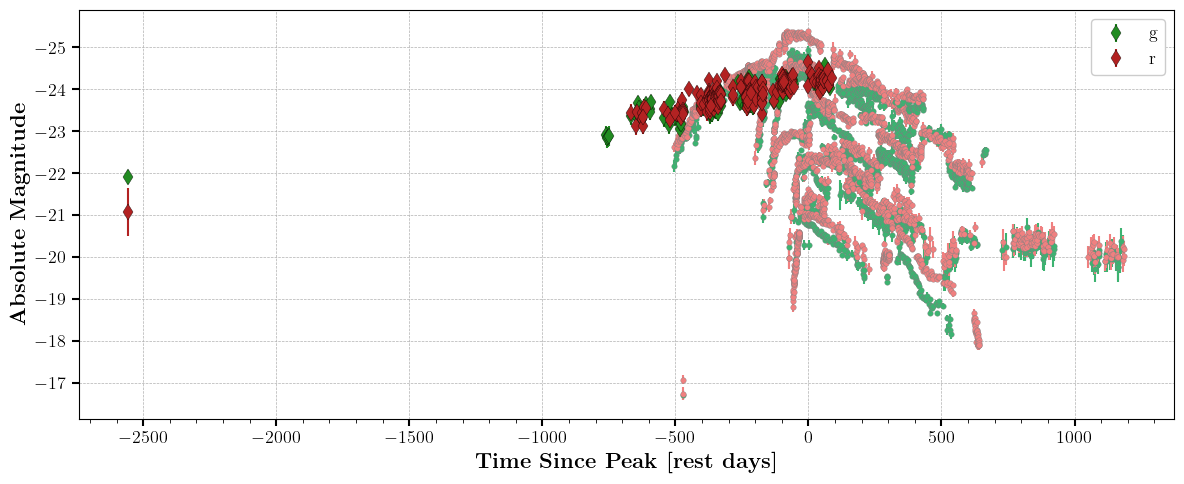

In [75]:
plt.figure(figsize=(12, 5))

for ztf_id in lightcurves.keys():
    for band, color in zip(('ZTF_g', 'ZTF_r'), ('mediumseagreen', 'lightcoral')):
        band_mask = lightcurves[ztf_id]['band'] == band
        plt.errorbar(
            lightcurves[ztf_id][band_mask]['rest_time'],
            lightcurves[ztf_id][band_mask]['abs_mag'],
            lightcurves[ztf_id][band_mask]['magerr'],
            fmt='o',
            markersize=4,
            color=color,
            markeredgecolor='gray',
            markeredgewidth=0.25,
        )

for band, color in zip(('g', 'r'), ('forestgreen', 'firebrick', 'darkorchid')):
    plt.errorbar(
        candidate_lc['rest_time'].filled(np.nan),
        candidate_lc[f'{band}Model_mag_abs'].filled(np.nan),
        candidate_lc[f'{band}Model_magerr'].filled(np.nan),
        fmt='o',
        label=band,
        markersize=8,
        markerfacecolor=color,
        ecolor=color,
        markeredgecolor='black',
        markeredgewidth=0.25,
        marker='d',
    )
    plt.errorbar(
        candidate_lc['rest_time'].filled(np.nan),
        candidate_lc[f'{band}_mag_abs'].filled(np.nan),
        candidate_lc[f'{band}_magerr'].filled(np.nan),
        fmt='o',
        markersize=8,
        markerfacecolor=color,
        ecolor=color,
        markeredgecolor='black',
        markeredgewidth=0.25,
        marker='d',
    )

plt.xlabel(r'\textbf{Time Since Peak [rest days]}', fontsize=16)
plt.ylabel(r'\textbf{Absolute Magnitude}', fontsize=16)

plt.ylim(plt.ylim()[::-1])

plt.legend(loc='upper right', framealpha=1, fontsize=13)

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(100))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

plt.tick_params(which='both', labelsize=13)
plt.tick_params(which='minor', length=3)
plt.tick_params(which='major', length=5, width=1.5)

plt.grid(which='major', linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.savefig('/Users/adamboesky/Research/long_transients/Figures/ants_vs_candidate.pdf', bbox_inches='tight')

plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_95107/3973251273.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_95107/3973251273.py:35: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


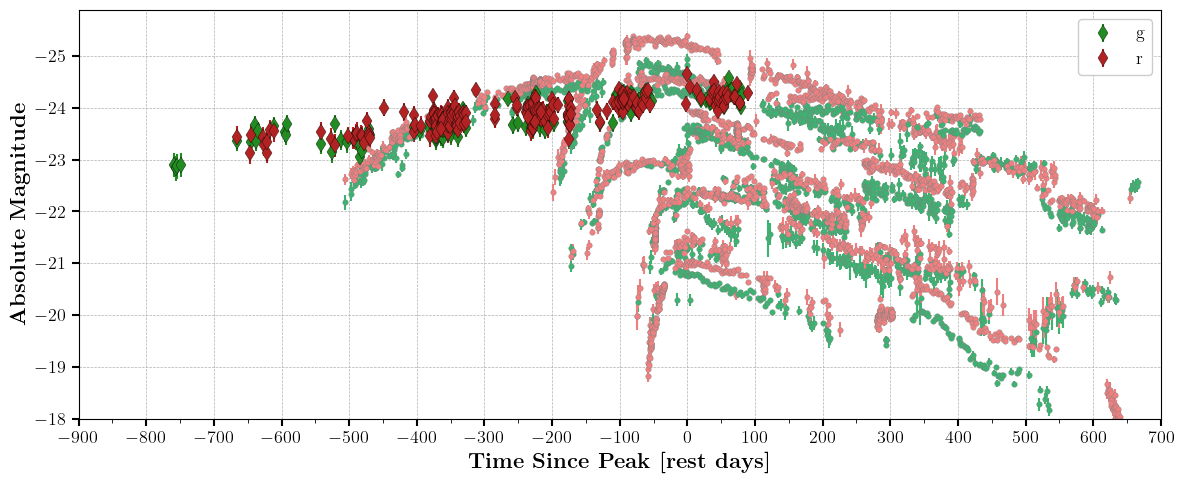

In [24]:
plt.figure(figsize=(12, 5))

x_range = (-900, 700)

for ztf_id in lightcurves.keys():
    for band, color in zip(('ZTF_g', 'ZTF_r'), ('mediumseagreen', 'lightcoral')):
        band_mask = lightcurves[ztf_id]['band'] == band
        band_mask &= (lightcurves[ztf_id][band_mask]['rest_time'] > x_range[0]) & (lightcurves[ztf_id][band_mask]['rest_time'] < x_range[1])
        plt.errorbar(
            lightcurves[ztf_id][band_mask]['rest_time'],
            lightcurves[ztf_id][band_mask]['abs_mag'],
            lightcurves[ztf_id][band_mask]['magerr'],
            fmt='o',
            markersize=4,
            color=color,
            markeredgecolor='gray',
            markeredgewidth=0.25,
        )

for band, color in zip(('g', 'r'), ('forestgreen', 'firebrick', 'darkorchid')):
    time_mask = (candidate_lc['rest_time'] > x_range[0]) & (candidate_lc['rest_time'] < x_range[1])
    plt.errorbar(
        candidate_lc['rest_time'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}Model_mag_abs'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}Model_magerr'].filled(np.nan)[time_mask],
        fmt='o',
        label=band,
        markersize=8,
        markerfacecolor=color,
        ecolor=color,
        markeredgecolor='black',
        markeredgewidth=0.25,
        marker='d',
    )
    plt.errorbar(
        candidate_lc['rest_time'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}_mag_abs'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}_magerr'].filled(np.nan)[time_mask],
        fmt='o',
        markersize=8,
        markerfacecolor=color,
        ecolor=color,
        markeredgecolor='black',
        markeredgewidth=0.25,
        marker='d',
    )

plt.xlabel(r'\textbf{Time Since Peak [rest days]}', fontsize=16)
plt.ylabel(r'\textbf{Absolute Magnitude}', fontsize=16)

plt.ylim(plt.ylim()[::-1])

plt.legend(loc='upper right', framealpha=1, fontsize=13)

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(100))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

plt.tick_params(which='both', labelsize=13)
plt.tick_params(which='minor', length=3)
plt.tick_params(which='major', length=5, width=1.5)

plt.grid(which='major', linestyle='--', linewidth=0.5)

plt.xlim(x_range)
plt.ylim(bottom=-18)

plt.tight_layout()

plt.savefig('/Users/adamboesky/Research/long_transients/Figures/ants_vs_candidate_shortened.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# Subtract peak time from the observed time as well
candidate_lc['mjd'] = candidate_lc['mjd'] - candidate_lc['mjd'][np.argmin(candidate_lc['g_mag'])]

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/3206811209.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/3206811209.py:43: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


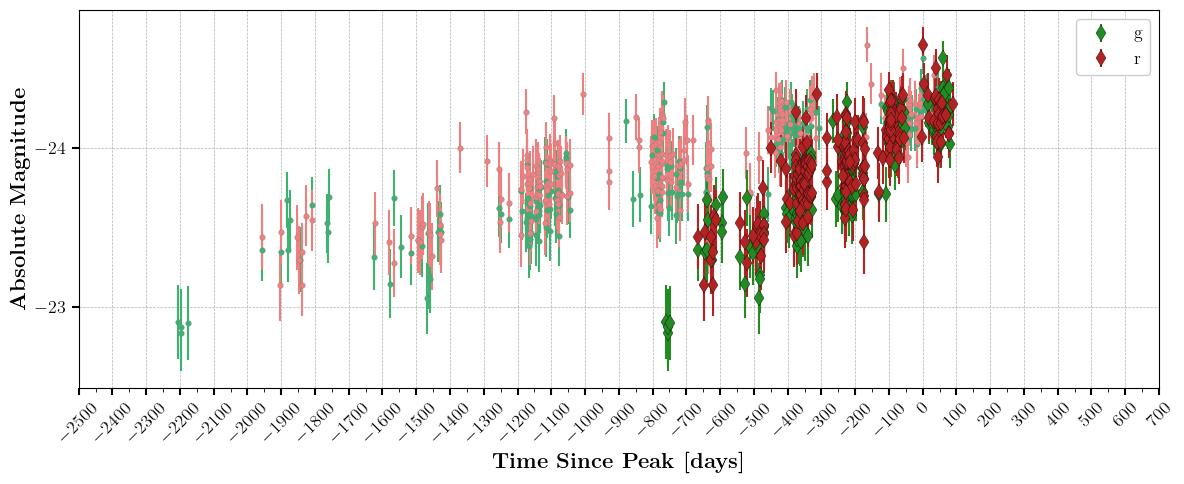

In [402]:
plt.figure(figsize=(12, 5))

x_range = (-2500, 700)

for band, color in zip(('g', 'r'), ('mediumseagreen', 'lightcoral')):
    time_mask = (candidate_lc['mjd'] > x_range[0]) & (candidate_lc['mjd'] < x_range[1])
    plt.errorbar(
        candidate_lc['mjd'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}Model_mag_abs'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}Model_magerr'].filled(np.nan)[time_mask],
        fmt='o',
        markersize=4,
        color=color,
        markeredgecolor='gray',
        markeredgewidth=0.25,
    )
    plt.errorbar(
        candidate_lc['mjd'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}_mag_abs'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}_magerr'].filled(np.nan)[time_mask],
        fmt='o',
        markersize=4,
        color=color,
        markeredgecolor='gray',
        markeredgewidth=0.25,
    )

for band, color in zip(('g', 'r'), ('forestgreen', 'firebrick', 'darkorchid')):
    time_mask = (candidate_lc['rest_time'] > x_range[0]) & (candidate_lc['rest_time'] < x_range[1])
    plt.errorbar(
        candidate_lc['rest_time'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}Model_mag_abs'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}Model_magerr'].filled(np.nan)[time_mask],
        fmt='o',
        label=band,
        markersize=8,
        markerfacecolor=color,
        ecolor=color,
        markeredgecolor='black',
        markeredgewidth=0.25,
        marker='d',
    )
    plt.errorbar(
        candidate_lc['rest_time'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}_mag_abs'].filled(np.nan)[time_mask],
        candidate_lc[f'{band}_magerr'].filled(np.nan)[time_mask],
        fmt='o',
        markersize=8,
        markerfacecolor=color,
        ecolor=color,
        markeredgecolor='black',
        markeredgewidth=0.25,
        marker='d',
    )


plt.xlabel(r'\textbf{Time Since Peak [days]}', fontsize=16)
plt.ylabel(r'\textbf{Absolute Magnitude}', fontsize=16)

plt.ylim(plt.ylim()[::-1])

plt.legend(loc='upper right', framealpha=1, fontsize=13)

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(100))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

plt.tick_params(which='both', labelsize=13)
plt.tick_params(which='minor', length=3)
plt.tick_params(which='major', length=5, width=1.5)
plt.tick_params(axis='x', rotation=45)

plt.grid(which='major', linestyle='--', linewidth=0.5)

plt.xlim(x_range)

plt.tight_layout()

plt.show()

# Distribution of WISE Colors

In [49]:
from astropy.table import vstack
from Source_Analysis.Sources import Sources

In [51]:
g_cat_0 = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/0_g.ecsv')
r_cat_0 = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/0_i.ecsv')
i_cat_0 = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/0_r.ecsv')
coords_0 = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/0_coords.ecsv')

g_cat_1 = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/1_g.ecsv')
r_cat_1 = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/1_i.ecsv')
i_cat_1 = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/1_r.ecsv')
coords_1 = load_ecsv('/Users/adamboesky/Research/long_transients/Data/filter_results/combined/1_coords.ecsv')

g_cat = vstack([g_cat_0, g_cat_1])
r_cat = vstack([r_cat_0, r_cat_1])
i_cat = vstack([i_cat_0, i_cat_1])

all_coords = vstack([coords_0, coords_1])
all_coords

ra,dec
float64,float64
224.67673410322453,-26.976228261428844
96.24213994778913,13.336101981421894
12.811636040795708,58.668321610248334
9.56139841742069,-24.98396394360872
96.52871095551752,13.180466806534795
223.2894605337383,21.901536919825432
352.5509585158785,-24.804052230076703
96.07996306212624,13.043529399551952
234.3963252840792,21.740196920016324


In [359]:
candidate_lcs = [Light_Curve(ra, dec, catalogs=['wise']) for ra, dec in all_coords[['ra', 'dec']]]

In [372]:
mean_wise_diffs = []
for lc in candidate_lcs:
    mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))
mean_wise_diffs = np.array(mean_wise_diffs)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...
Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_14236/4089154358.py:3: RuntimeWarning: Mean of empty slice
  mean_wise_diffs.append(np.nanmean(lc.lc['w1_mag'].filled(np.nan) - lc.lc['w2_mag'].filled(np.nan)))


Querying wise catalog for light curve...


In [422]:
with open('/Users/adamboesky/Research/long_transients/Data/mean_wise_colors.npy', 'wb') as f:
    np.save(f, mean_wise_diffs)

In [195]:
mean_wise_diffs = np.load('/Users/adamboesky/Research/long_transients/Data/mean_wise_colors.npy')
len(mean_wise_diffs)

310

In [87]:
non_nan_mean_wise_diffs = mean_wise_diffs[~np.isnan(mean_wise_diffs)]
np.sum(non_nan_mean_wise_diffs > 0.8) / len(non_nan_mean_wise_diffs), np.sum(non_nan_mean_wise_diffs < 0.8), len(non_nan_mean_wise_diffs)

(0.9106382978723404, 21, 235)

In [196]:
np.sum(non_nan_mean_wise_diffs > 0.8), np.sum(non_nan_mean_wise_diffs < 0.8), len(non_nan_mean_wise_diffs)

(214, 21, 235)

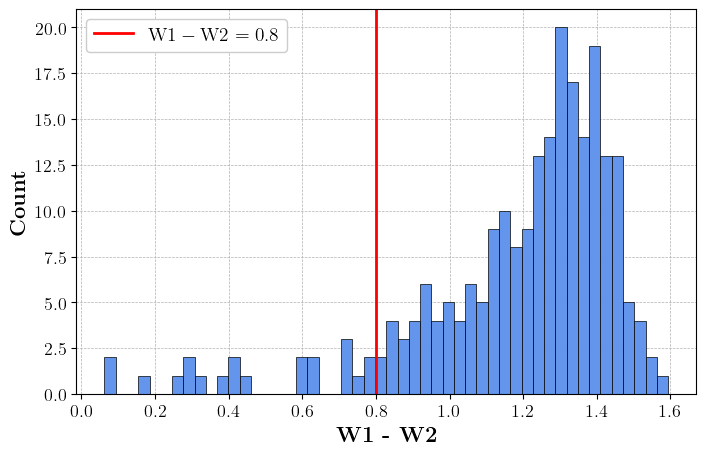

In [424]:
plt.figure(figsize=(8, 5))

plt.hist(mean_wise_diffs, bins=50, color='cornflowerblue', edgecolor='black', zorder=2, lw=0.5)
plt.axvline(0.8, color='red', lw=2, label=r'$\rm{W}1 - \rm{W}2 = 0.8$')
plt.grid(linestyle='--', linewidth=0.5, zorder=-1)
plt.legend(loc='upper left', fontsize=14, framealpha=1)

plt.tick_params(which='both', labelsize=13)

plt.xlabel(r'\textbf{W1 - W2}', fontsize=16)
plt.ylabel(r'\textbf{Count}', fontsize=16)

plt.savefig('/Users/adamboesky/Research/long_transients/Figures/wise_color_distribution.pdf', bbox_inches='tight')

plt.show()

# LCs for sources with W1 - W2 < 0.8

In [221]:
non_agn_mask = mean_wise_diffs < 0.8
print(f'Number of non-AGN candidates selected by WISE color = {np.sum(non_agn_mask)}')

non_agn_srcs = Sources(
    ras=all_coords[non_agn_mask]['ra'],
    decs=all_coords[non_agn_mask]['dec'],
    max_arcsec=3,
    field_catalogs={'g': g_cat, 'r': r_cat, 'i': i_cat},
)

Number of non-AGN candidates selected by WISE color = 21


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_36274/842688236.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))


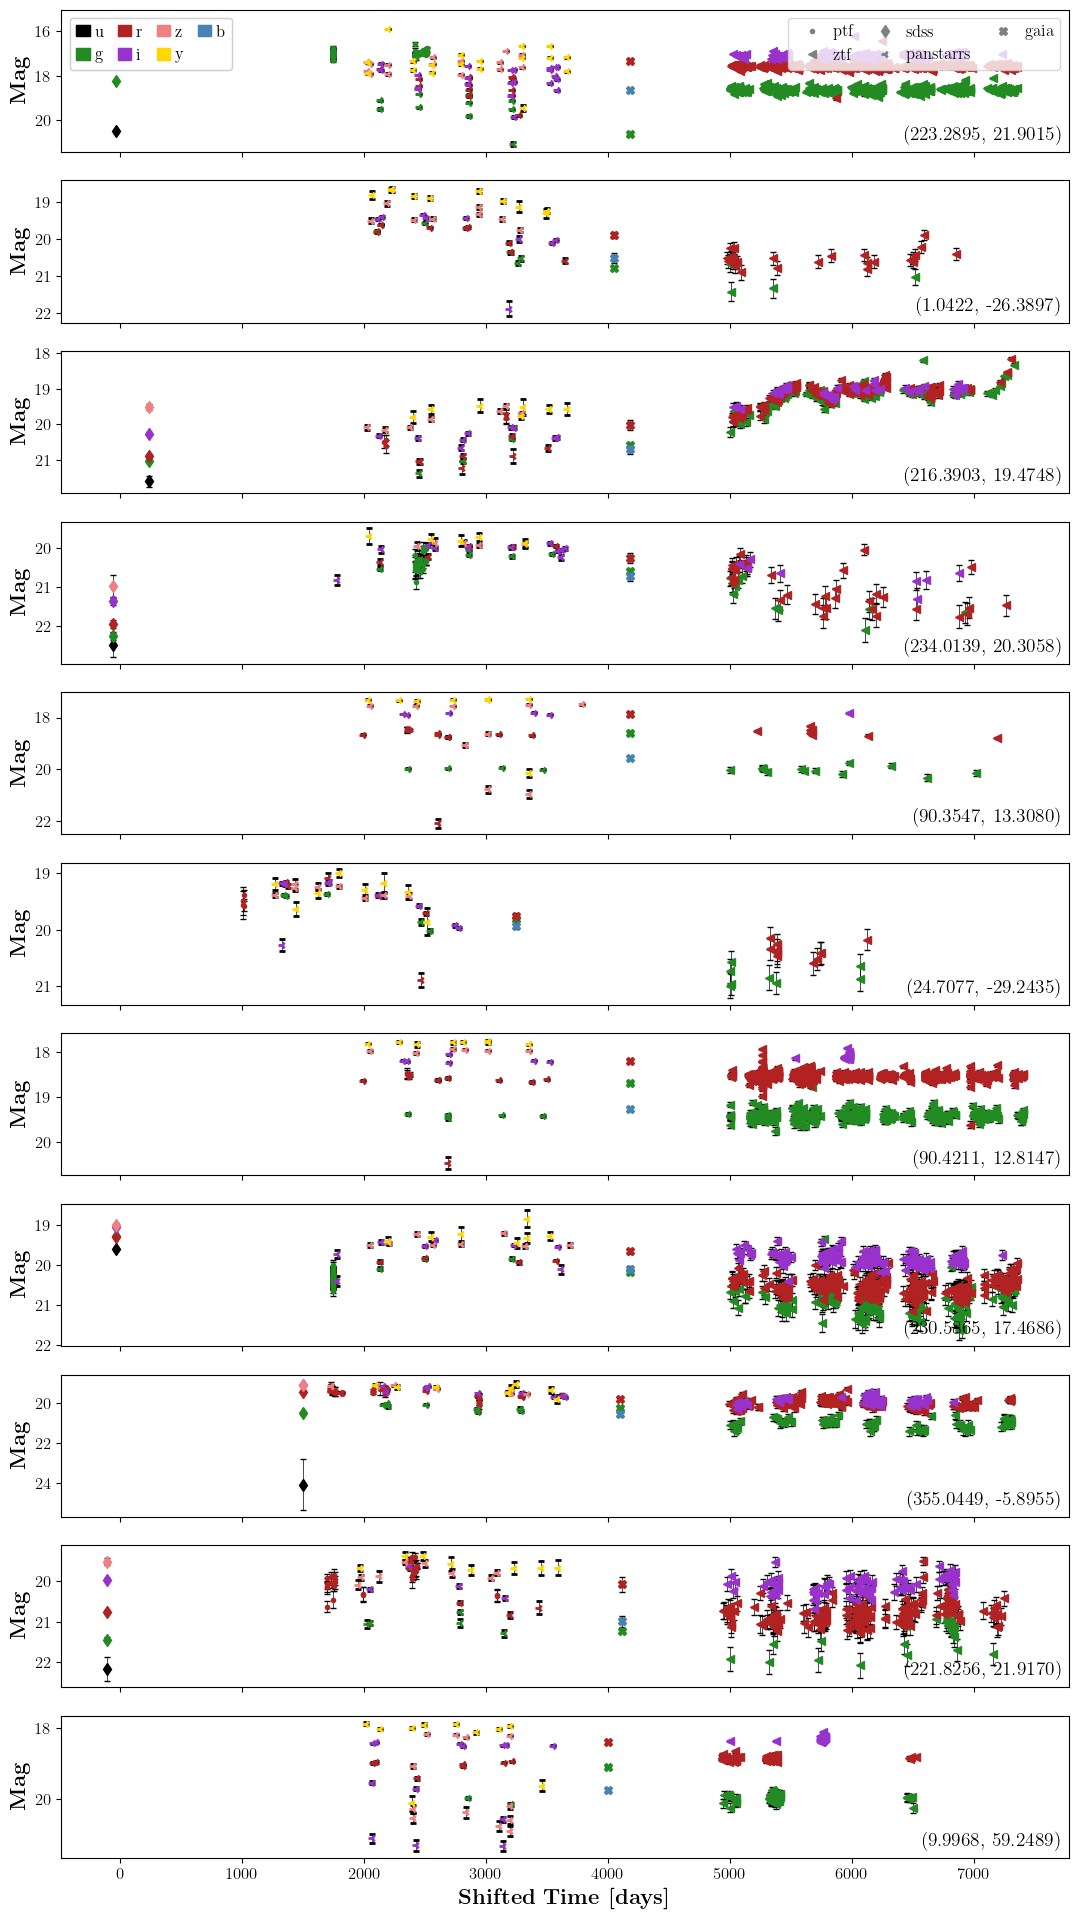

/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_36274/842688236.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))


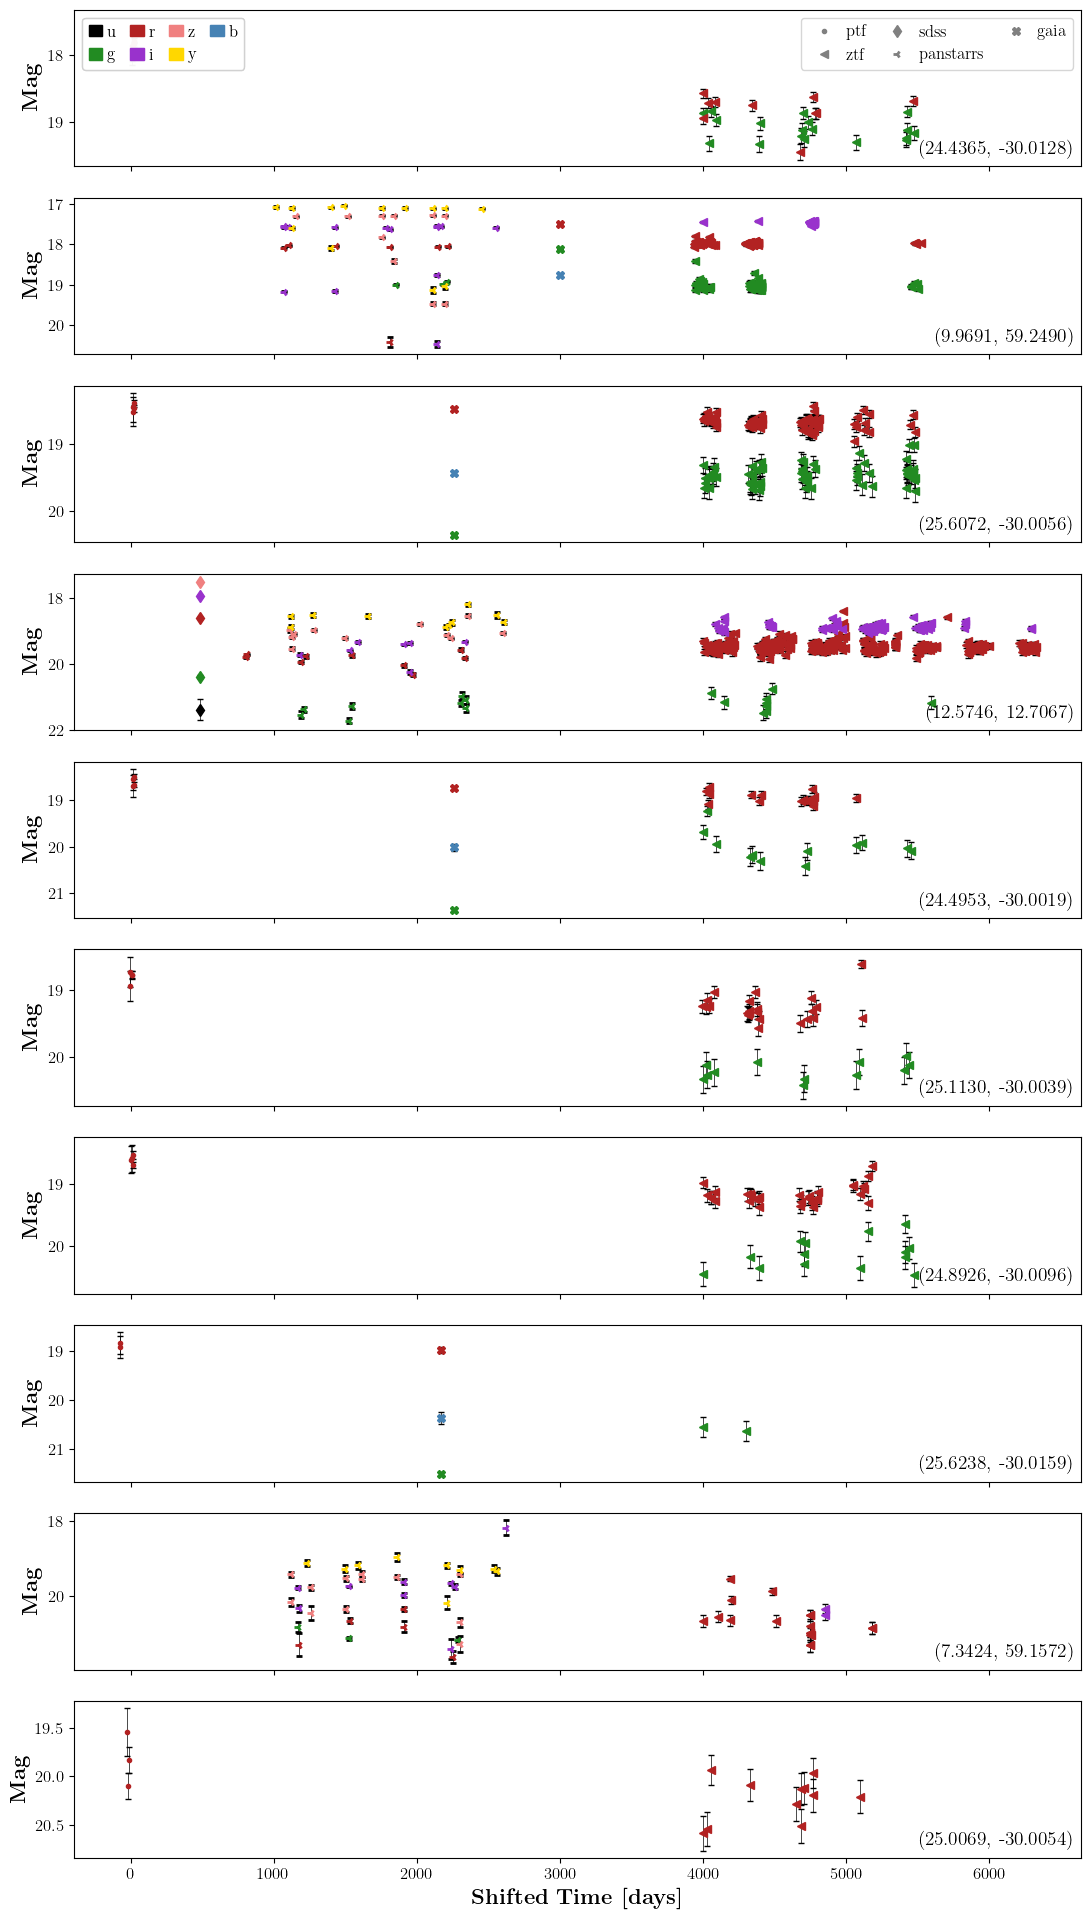

In [223]:
fig, axes = plt.subplots(11, 1, figsize=(13, 24), sharex=True)
# fig, axes = plt.subplots(3, 1, figsize=(13, 10), sharex=True)

# Plot the light curves
for i, (ax, src) in enumerate(zip(axes, non_agn_srcs)):
    src.plot_lc(ax=ax, include_wise=False, include_legend=True if i == 0 else False, time_since_peak=True, time_as_str=False)
    ax.set_xlabel('')
    ax.set_ylabel(r'\textbf{Mag}', fontsize=16)
    ax.annotate(f'({src.ra:.4f}, {src.dec:.4f})', xy=(0.995, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=14, color='black')

# plt.tight_layout()  # Commented out to avoid layout conflicts
axes[-1].set_xlabel(r'\textbf{Shifted Time [days]}', fontsize=16)
axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))

plt.savefig('/Users/adamboesky/Research/long_transients/Figures/not_agn_wise_0.pdf', bbox_inches='tight')

plt.show()

fig, axes = plt.subplots(10, 1, figsize=(13, 24), sharex=True)
# fig, axes = plt.subplots(3, 
# 1, figsize=(13, 10), sharex=True)

# Plot the light curves
for i, (ax, src) in enumerate(zip(axes, non_agn_srcs[11:])):
    src.plot_lc(ax=ax, include_wise=False, include_legend=True if i == 0 else False, time_since_peak=True, time_as_str=False)
    ax.set_xlabel('')
    ax.set_ylabel(r'\textbf{Mag}', fontsize=16)
    ax.annotate(f'({src.ra:.4f}, {src.dec:.4f})', xy=(0.995, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=14, color='black')

# plt.tight_layout()  # Commented out to avoid layout conflicts
axes[-1].set_xlabel(r'\textbf{Shifted Time [days]}', fontsize=16)
axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))

plt.savefig('/Users/adamboesky/Research/long_transients/Figures/not_agn_wise_1.pdf', bbox_inches='tight')

plt.show()

# Examples of Variable and Transient-Like

In [25]:
from Source_Analysis.Light_Curve import Light_Curve

In [26]:
transient_coords = [(221.68790, 17.96113), (352.55096, -24.80405), (355.63845, -27.83100)]
variable_coords = [(8.47160, 5.18897), (223.14901, 22.52090), (216.39033, 19.47478)]  # in order: spec-confirmed QSO, WISE AGN, WISE not AGN

transient_srcs = Sources(
    ras=[ra for ra, _ in transient_coords],
    decs=[dec for _, dec in transient_coords],
    field_catalogs={'g': g_cat, 'r': r_cat, 'i': i_cat},
)
variable_srcs = Sources(
    ras=[ra for ra, _ in variable_coords],
    decs=[dec for _, dec in variable_coords],
    field_catalogs={'g': g_cat, 'r': r_cat, 'i': i_cat},
)

/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_36274/595738859.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))


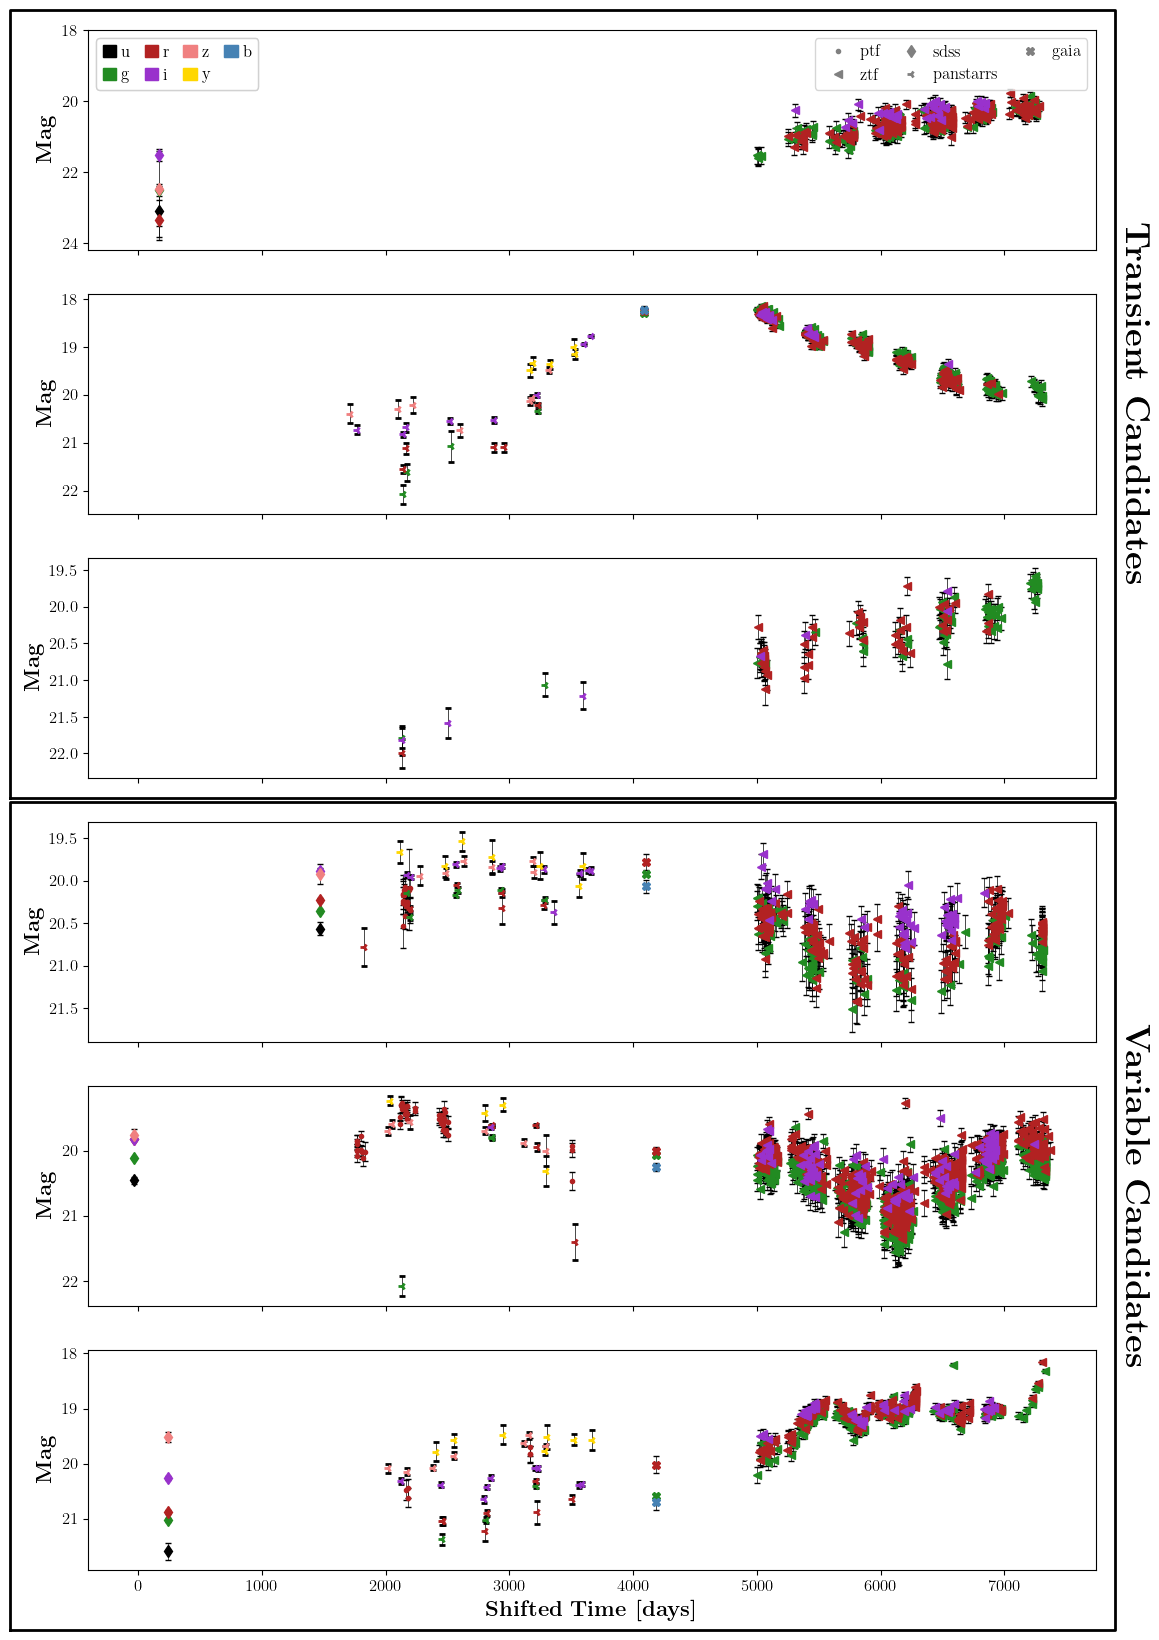

In [61]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize=(13, 20), sharex=True)

# Plot the light curves
for i, src in enumerate(transient_srcs):
    src.plot_lc(ax=axes[i], include_wise=False, include_legend=True if i == 0 else False, time_since_peak=True, time_as_str=False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(r'\textbf{Mag}', fontsize=16)
for i, src in enumerate(variable_srcs):
    src.plot_lc(ax=axes[i + len(transient_srcs)], include_wise=False, include_legend=False, time_since_peak=True, time_as_str=False)
    axes[i + len(transient_srcs)].set_xlabel('')
    axes[i + len(transient_srcs)].set_ylabel(r'\textbf{Mag}', fontsize=16)
axes[0].set_ylim((24.2, 18))

# plt.tight_layout()  # Commented out to avoid layout conflicts
axes[-1].set_xlabel(r'\textbf{Shifted Time [days]}', fontsize=16)

# Function to add a vertical bracket and label
def add_bracket(fig, axes, top_idx, bottom_idx, label, x_offset=0.02, include_xlab=False):
    """ Adds a vertical bracket with a label to a set of axes. """
    
    # Get position of the top and bottom axes in figure coordinates
    y_top = axes[top_idx].get_position().y1
    y_bottom = axes[bottom_idx].get_position().y0
    x_right = axes[top_idx].get_position().x1 + x_offset - 0.015
    x_left = axes[top_idx].get_position().x0 + x_offset

    # Draw the bracket manually using `fig.transFigure`
    line_x = [x_left - 0.08, x_right + 0.01, x_right + 0.01, x_left - 0.08, x_left - 0.08]  # Shape of a bracket
    if include_xlab:
        line_y = [y_bottom - 0.03, y_bottom - 0.03, y_top + 0.01, y_top + 0.01, y_bottom - 0.03]  # Connects the two parts
    else:
        line_y = [y_bottom - 0.01, y_bottom - 0.01, y_top + 0.01, y_top + 0.01, y_bottom - 0.01]  # Connects the two parts

    fig.lines.append(plt.Line2D(line_x, line_y, transform=fig.transFigure, color='black', lw=2))

    # Add text label
    fig.text(x_right + 0.025, (y_top + y_bottom) / 2, label, va='center', ha='center', fontsize=25, fontweight='bold', rotation=-90)

# Add brackets for the top and bottom three plots
add_bracket(fig, axes, top_idx=0, bottom_idx=2, label=r"\textbf{Transient Candidates}")
add_bracket(fig, axes, top_idx=3, bottom_idx=5, label=r"\textbf{Variable Candidates}", include_xlab=True)

axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))

plt.savefig('/Users/adamboesky/Research/long_transients/Figures/transient_v_variable.pdf', bbox_inches='tight')

plt.show()

/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_95107/217748655.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))


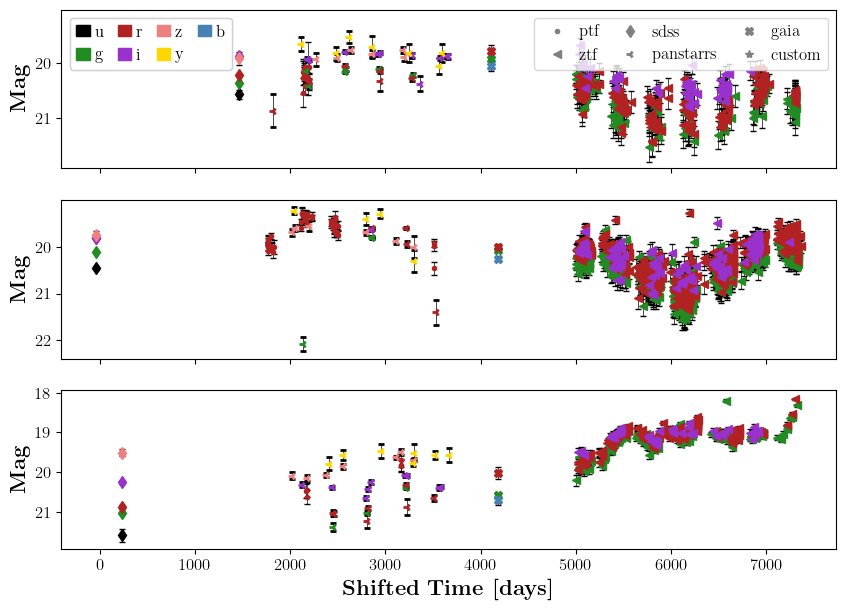

/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_95107/217748655.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))


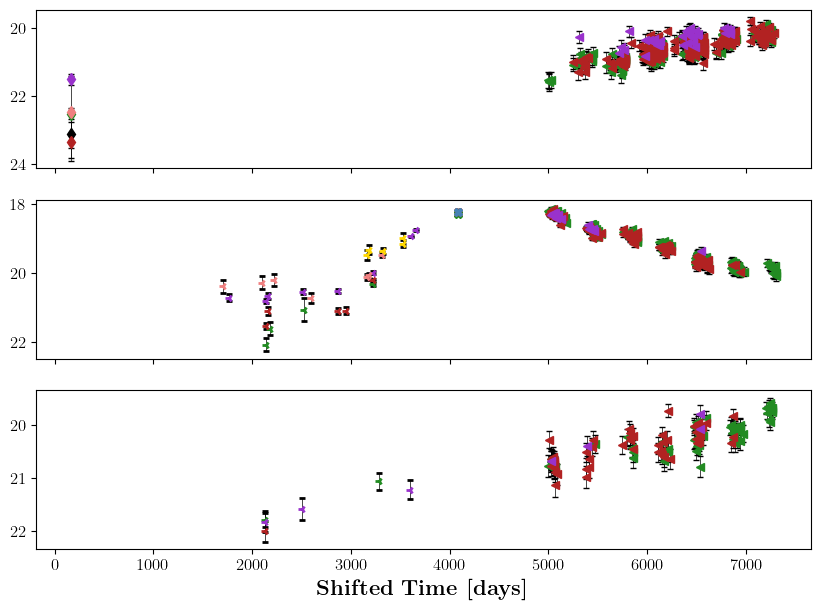

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

# Plot the light curves
for i, src in enumerate(variable_srcs):
    src.plot_lc(ax=axes[i], include_wise=False, include_legend=True if i == 0 else False, time_since_peak=True, time_as_str=False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(r'\textbf{Mag}', fontsize=16)

# plt.tight_layout()  # Commented out to avoid layout conflicts
axes[-1].set_xlabel(r'\textbf{Shifted Time [days]}', fontsize=16)
axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))

plt.show()

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

# Plot the light curves
for i, src in enumerate(transient_srcs):
    src.plot_lc(ax=axes[i], include_wise=False, include_legend=False, time_since_peak=True, time_as_str=False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# plt.tight_layout()  # Commented out to avoid layout conflicts
axes[-1].set_xlabel(r'\textbf{Shifted Time [days]}', fontsize=16)
axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))

plt.show()

/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


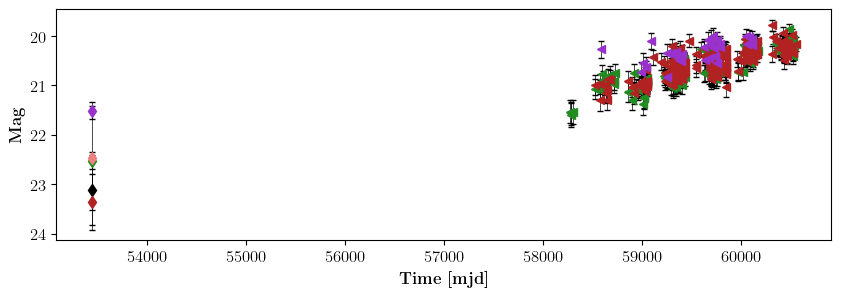

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), sharex=True)

transient_srcs[0].plot_lc(ax=ax, include_wise=False, include_legend=False, time_as_str=False)
ax.set_ylabel(r'\textbf{Mag}')
ax.set_xlabel(r'\textbf{Time [mjd]}')

plt.show()

# All Candidate Light Curves

In [93]:
transient_coords = [(221.68790, 17.96113), (352.55096, -24.80405), (355.63845, -27.83100), (234.01386, 20.30576),
                    (222.85809, 21.04046), (353.25359, -21.86496), (4.50252, -17.62821), (210.82191, 19.29498),
                    (234.10610, 21.32203), (227.82102, 19.62236)]

transient_srcs = Sources(
    ras=[ra for ra, _ in transient_coords],
    decs=[dec for _, dec in transient_coords],
    field_catalogs={'g': g_cat, 'r': r_cat, 'i': i_cat},
    lc_catalogs=['ztf'],
)

Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/astropy/table/column.py:1376: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/astropy/table/column.py:1376: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/astropy/table/column.py:1376: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/astropy/table/column.py:1376: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


Searching for source in the catalogs!
Searching g catalog for source...
Searching r catalog for source...
Searching i catalog for source...
Querying ztf catalog for light curve...


/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_36274/2432586371.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))


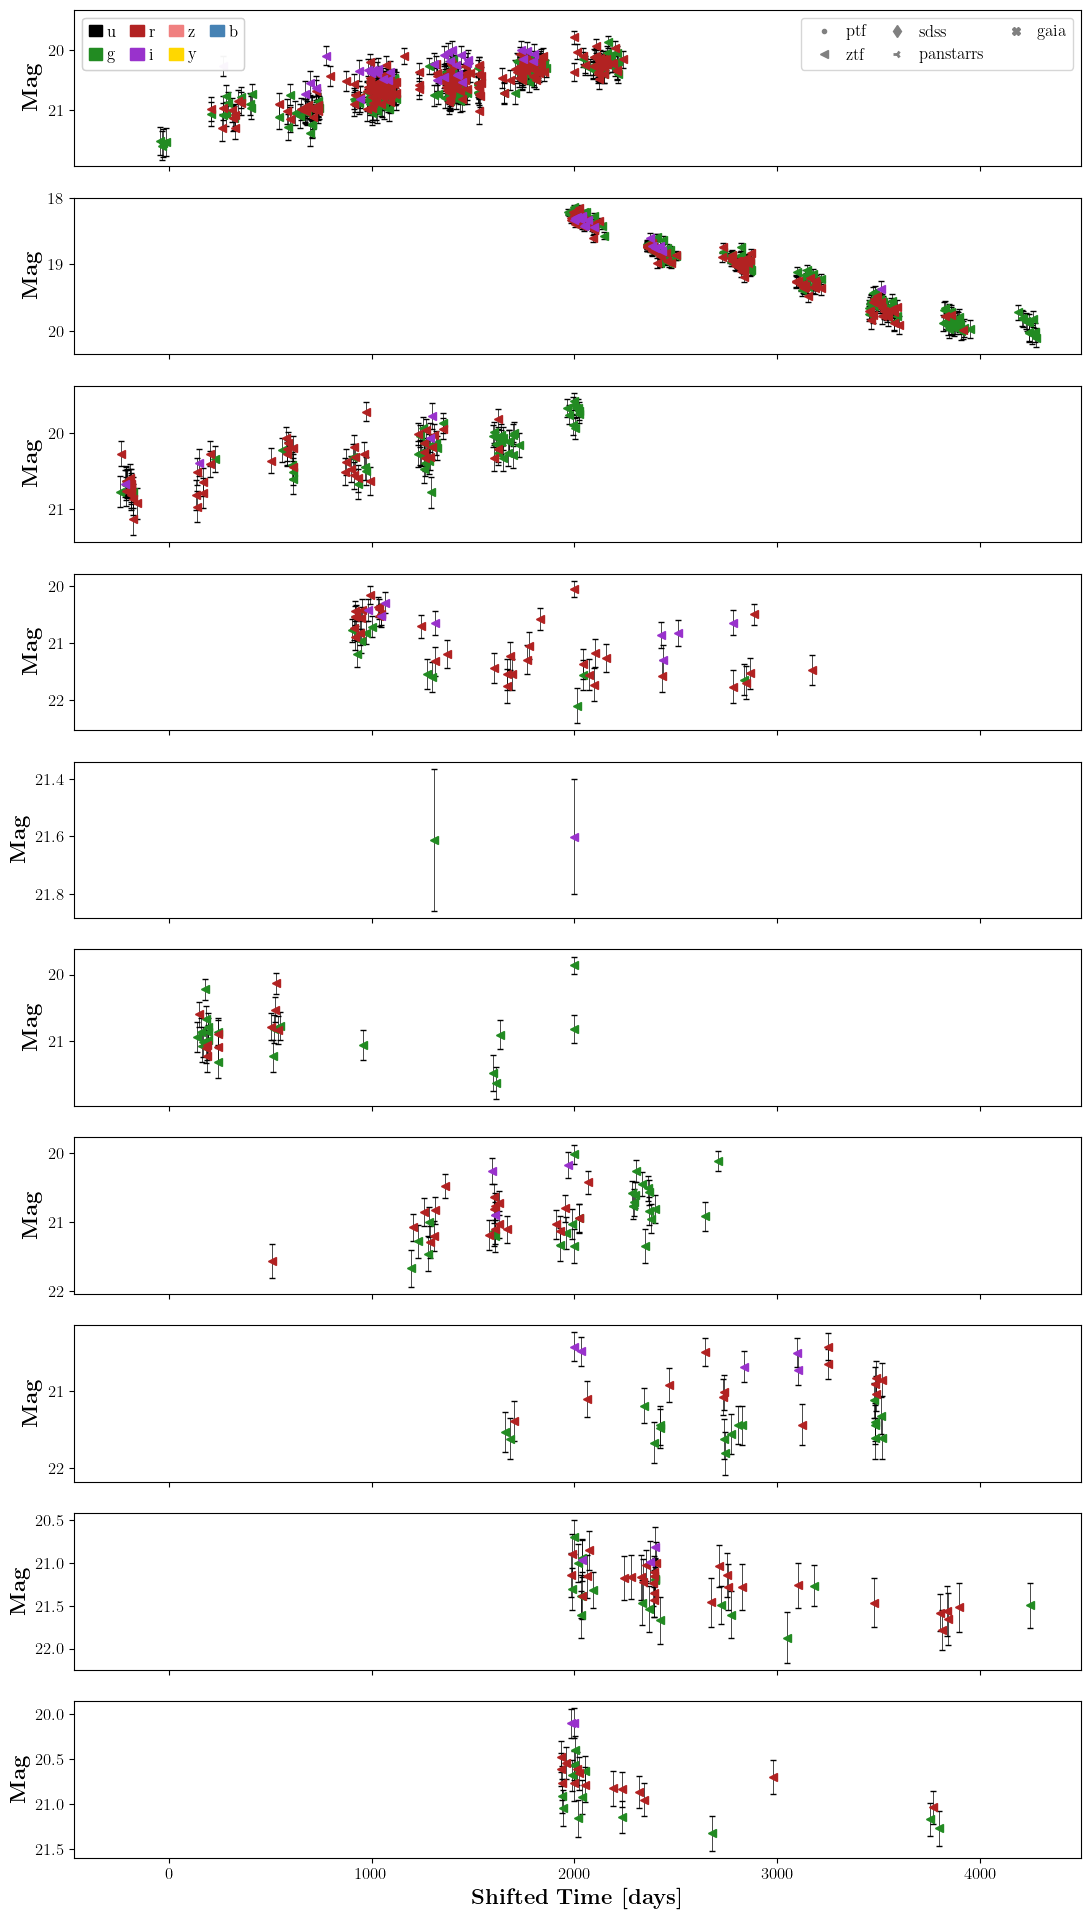

In [94]:
fig, axes = plt.subplots(10, 1, figsize=(13, 24), sharex=True)

# Plot the light curves
for i, src in enumerate(transient_srcs):
    src.plot_lc(ax=axes[i], include_wise=False, include_legend=True if i == 0 else False, time_since_peak=True, time_as_str=False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(r'\textbf{Mag}', fontsize=16)

# plt.tight_layout()  # Commented out to avoid layout conflicts
axes[-1].set_xlabel(r'\textbf{Shifted Time [days]}', fontsize=16)
axes[-1].set_xticklabels(np.arange(-1000, 8000, 1000))

plt.savefig('/Users/adamboesky/Research/long_transients/Figures/all_transients.pdf', bbox_inches='tight')

plt.show()

# Plot source spectrum

In [95]:
def bin_spectra(wavelength, flux, bin_width):
    """
    Bin the spectral data in bins of a specified width.
    
    Parameters
    ----------
    wavelength : array-like
        Wavelength values.
    flux : array-like
        Flux values.
    bin_width : float
        Bin width in Angstroms.
    
    Returns
    -------
    binned_wavelength, binned_flux : np.array, np.array
        The average wavelength and flux in each bin.
    """
    bins = np.arange(wavelength.min(), wavelength.max() + bin_width, bin_width)
    indices = np.digitize(wavelength, bins)
    binned_wavelength = []
    binned_flux = []
    for i in range(1, len(bins)):
        in_bin = indices == i
        if np.any(in_bin):
            binned_wavelength.append(np.mean(wavelength[in_bin]))
            binned_flux.append(np.mean(flux[in_bin]))

    return np.array(binned_wavelength), np.array(binned_flux)

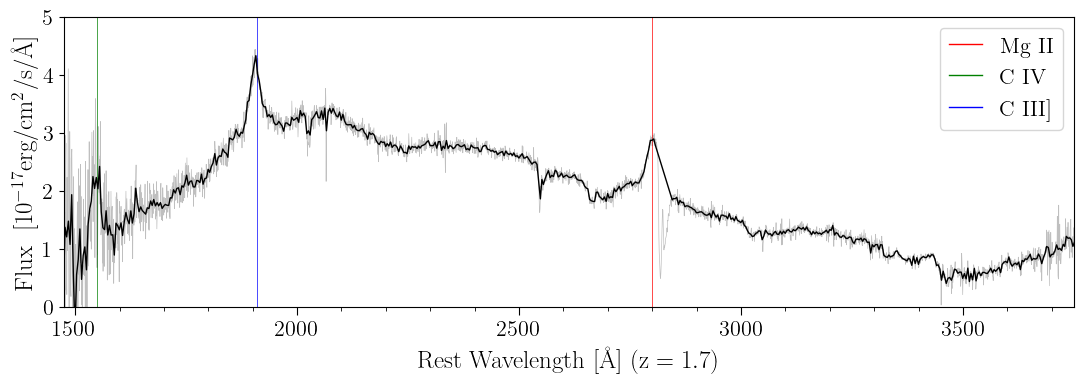

In [193]:
names     = ['31_candidate_221p68_17p961']
redshifts = [1.7]
ylims     = [5.0]

for object_name, redshift, y_lim in zip(names, redshifts, ylims):

    plt.figure(figsize=(11, 4))

    # Import Data
    wavelength, flux, sigma = np.genfromtxt(
        os.path.join('/Users/adamboesky/Research/long_transients/Data/spectra', f'{object_name}.txt'),
        unpack = True
    )

    # Bin Data
    good = (wavelength > 7580) & (wavelength < 7680)
    wavelength_bin, flux_bin = bin_spectra(wavelength[~good][50:-20], flux[~good][50:-20], 10)
    xgd_array = (wavelength_bin, flux_bin)

    # plt.title(object_name)
    plt.axvline(x = 2799.117, color = 'red', linewidth = 0.5, zorder = -1, label = 'Mg II')
    plt.axvline(x = 1549.48, color = 'green', linewidth = 0.5, zorder = -1, label = 'C IV')
    plt.axvline(x = 1908.734, color = 'blue', linewidth = 0.5, zorder = -1, label = 'C III]')
    # plt.axvline(x = 5183.000, color = 'r'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 5172.000, color = 'r'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 5167.000, color = 'r'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 2803.000, color = 'r'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 4958.911, color = 'k'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 5006.843, color = 'k'     , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'O')
    # plt.axvline(x = 6562.760, color = 'b'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 4861.327, color = 'b'     , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'H')
    # plt.axvline(x = 4686.000, color = 'orange', linewidth = 1, alpha = 0.5, linestyle = '--', label = 'He II')
    # plt.axvline(x = 3968.500, color = 'c'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 3933.700, color = 'c'     , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'Ca')
    # plt.axvline(x = 5889.950, color = 'pink'  , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 5895.924, color = 'pink'  , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'Na')
    # plt.axvline(x = 6548.000, color = 'gray'  , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 6584.000, color = 'gray'  , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'NII')

    leg = plt.legend(loc='upper right', fontsize=16, handlelength=1.5)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(1.0)

    plt.plot(wavelength / (1 + redshift), flux * 1E17, color = 'k', linewidth = 0.5, alpha = 0.25)
    plt.plot(wavelength_bin / (1 + redshift), flux_bin * 1E17, color = 'k', linewidth = 1)

    plt.xlim(1475, 3750)
    plt.ylim(0, y_lim)

    plt.xlabel(fr'Rest Wavelength [\AA] ($\rm{{z}} = {redshift}$)', fontsize = 18)
    plt.ylabel(r'Flux \ [$10^{-17}$erg/cm$^2$/s/\AA]', fontsize = 18)
    plt.xticks(np.arange(1500, 3800, 500), fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(100))
    plt.tick_params(axis='x', which='major', length=6)
    plt.tick_params(axis='x', which='minor', length=3)

    plt.tight_layout()

    plt.savefig(f'/Users/adamboesky/Research/long_transients/Figures/{object_name}_spectrum.pdf', bbox_inches='tight')

    plt.show()

    # plt.savefig('%s_compare.pdf'%object_name, bbox_inches = 'tight')
    #plt.show()
    # plt.clf(); plt.close('all')

# LC plot for source with custom photometry
The source's original analysis page can be found here: https://drive.google.com/file/d/18v4HR0ee9m-hrWqXDIZaFhf6lFc0sSpz/view

In [9]:
from Source_Analysis.Sources import Source

src = Source(210.82191, 19.29498, field_catalogs={'g': g_cat, 'r': r_cat, 'i': i_cat}, max_arcsec=3)

/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:898: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:923: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  wise_ax.errorbar(
/Users/adamboesky/Research/long_transients/Source_Analysis/Sources.py:933: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  wise_ax.errorbar(


(22.23032325451747, 18.4)

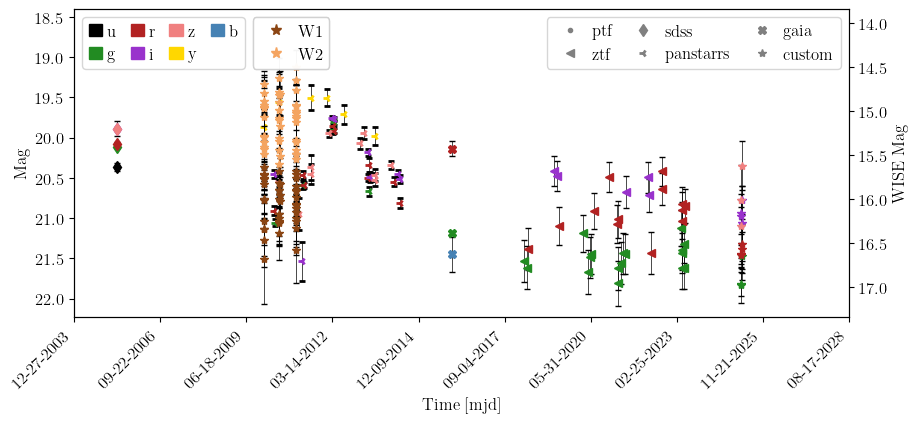

In [15]:
axes = src.plot_lc()
axes[0].get_ylim()
axes[0].set_ylim((22.23032325451747, 18.4))

# Getting stats on TNS and SDSS

In [52]:
all_srcs = Sources(
    ras=all_coords['ra'],
    decs=all_coords['dec'],
    max_arcsec=3,
    field_catalogs={'g': g_cat, 'r': r_cat, 'i': i_cat},
)

In [61]:
tns_types = []
for i, src in enumerate(all_srcs):
    if i % 10 == 0:
        print(f'{i} / {len(all_srcs)}')
    tns_info = src.get_TNS_info()
    if tns_info is not None:
        tns_types.append(tns_info['type'])

0 / 310
10 / 310
20 / 310
30 / 310
40 / 310
50 / 310
60 / 310
70 / 310
80 / 310
90 / 310
100 / 310
110 / 310
120 / 310
130 / 310
140 / 310
150 / 310
160 / 310
170 / 310
180 / 310
190 / 310
200 / 310
210 / 310
220 / 310
230 / 310
240 / 310
250 / 310
260 / 310
270 / 310
280 / 310
290 / 310
300 / 310


In [68]:
len(tns_types)

5

In [62]:
sdss_types = []
for i, src in enumerate(all_srcs):
    if i % 10 == 0:
        print(f'{i} / {len(all_srcs)}')
    spec = src.spectrum
    if spec is not None:
        sdss_types.append(spec[0][2].data["CLASS"])

0 / 310
Getting source spectrum from SDSS...
Source at (224.67673410322453, -26.976228261428844) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (96.24213994778913, 13.336101981421894) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (12.811636040795708, 58.668321610248334) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (9.56139841742069, -24.98396394360872) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (96.52871095551752, 13.180466806534795) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (352.5509585158785, -24.804052230076703) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (96.07996306212624, 13.043529399551952) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (234.3963252840792, 21.740196920016324) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (90.11800

Getting source spectrum from SDSS...
Source at (216.49740649587983, 22.36826043201853) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (222.36145126933133, 18.847038336578706) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (90.42107504412512, 12.81467846918894) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (356.36646069779783, -5.49925993067755) has no spectrum in SDSS.
50 / 310
Getting source spectrum from SDSS...
Source at (7.068967870869191, 7.50313128365157) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (223.7237436773292, 19.24554820885335) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (223.8855241780007, 21.168383210341148) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (90.526106821384, 13.39031411256141) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (227.55795757483327, 21.760674170904405) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (89.85118863305374, 13.361987344808435) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (359.245593779122

Getting source spectrum from SDSS...
Source at (0.7197525548997039, -25.417368989630106) has no spectrum in SDSS.
60 / 310
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (219.7807427857614, 16.466387284433907) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (228.9466137296165, 16.569890818594374) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (218.56559318139884, 18.418052439069136) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (1.8395531460105503, -25.64365231490233) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (1.766221092587462, 5.709228459201855) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (33.3031299814166, 9.504863507145316) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (215.43681043571743, 21.296615011487617) has no spectrum in SDSS.
70 / 310
Getting source spectrum from SDSS...
Source at (217.1136702702412, 19.85513179928884) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (208.3943201545636, 21.09864310727968) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (232.28995938629623, 17.224482171378938) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (358.2782859920262, -21.25722442435864) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (231.51985266997409, 16.259624535090587) has no spec

Getting source spectrum from SDSS...
Source at (217.42584355919465, 20.35547046475512) has no spectrum in SDSS.
80 / 310
Getting source spectrum from SDSS...
Source at (225.21910225183552, 19.52761165933171) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (209.2523280590813, 22.31994953613532) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (8.570587417959862, 7.982455257342603) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (210.8219075697258, 19.29498375059042) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (230.22560016148933, 21.72971494858421) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (354.66413044979925, -21.597089106449417) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (355.8914794665635, -3.006844112770352) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (218.8411774471305, 17.26502828480463) has no spectrum in SDSS.
90 / 310
Getting source spectrum from SDSS...
Source at (210.4112318336525, 21.78168798922709) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (345.4606788165992, -3.2338054080731955) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (207.83858022999183, 17.859565659694034) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (355.04485391079083, -5.8954991241178725) has n

Getting source spectrum from SDSS...
Source at (358.3398072004245, -23.420897789733587) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (234.1060971525036, 21.32202914869672) has no spectrum in SDSS.
100 / 310
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (358.284918942904, -25.232192073674582) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (4.261663411357612, -23.736733324893923) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (226.28357971972545, 19.57130386962379) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (228.9862594343581, 17.958123813334765) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (352.64565994753127, -24.851160678406977) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (218.1430757481091, 20.61505809812021) has no spectrum in SDSS.
Getting source spe

110 / 310
Getting source spectrum from SDSS...
Source at (89.84134394426027, 13.163128898889068) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (12.503466059744442, -27.761423351895765) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (227.82102181847887, 19.62235607228469) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (222.3533987765797, 16.391502822616243) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (229.91664109720728, 17.75682938110588) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (223.91685891947063, 16.640010322770525) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (2.8895703400962365, 8.075293820079583) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (212.76162509539893, 19.16625233851682) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (19.39477357041322, 12.766362103312822) has 

Source at (353.48217025999634, -23.043134196402004) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (234.2829524610785, 19.64087447003997) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (351.6286204352956, -5.49111405434649) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (215.11494708291377, 20.703063025339127) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (217.5976058122844, 20.39921499551528) has no spectrum in SDSS.
130 / 310
Getting source spectrum from SDSS...
Source at (229.58272953813164, -23.01172997695916) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (206.3275324169696, 19.71412483930247) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (223.1490083416704, 22.52090187097109) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (215.972779

Source at (223.02827899971032, 20.728573436099587) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (210.4595980660099, 20.00226615123345) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (357.8775508365527, -3.85243533331484) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (231.99434236089527, 21.77006306258553) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (212.28864028885656, 22.192978952906195) has no spectrum in SDSS.
160 / 310
Getting source spectrum from SDSS...
Source at (0.7367446768048627, -25.7845231076354) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (216.8965749316778, 17.437040056669247) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (231.0224005777376, 21.59365206173176) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (234.1925427880003, 17.2634789415265) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (225.13490543224555, 15.219437648338287) has no spectrum in SDSS.
Getting source spectrum from SDSS...
170 / 310
Getting source spectrum from SDSS...
Source at (220.7190150742385, 16.78393051113816) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (227.6785613415456, 18.709341911366494) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (89.92690510006057, 13.12602091417817) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (208.0498178207334, 21.09643067863033) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (209.41158031552607, 19.139472196937387) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (357.711331016493, -6.135270201161447) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (217.1046653636986, 19.64259789814101) has no spectrum in SDSS.
180 / 310
Getting source spectrum from SDSS...
Source at (352.6139575161089, -4.9353054980557065) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (354.9182478869585, -27.779049824782195) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (228.08863217786265, 20.02705226018726) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (356.570803831277, -25.308955207137046) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (215.14587264135105, 15.976147184852104) has no

Getting source spectrum from SDSS...
Source at (207.1511464371435, 20.559911559649287) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (232.1485048423885, 21.69046648880916) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (229.987507907849, 18.086058738446628) has no spectrum in SDSS.
190 / 310
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (2.862012031595235, 5.565277558941119) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (218.6941364294057, 16.011085960481736) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (219.90890360492392, 22.508214262372235) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (213.67716028389725, 16.412960454331017) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (222.4162346187042, 19.53779305137804) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (230.69369158253585, 15.242784837832808) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (231.22860859763304, 22.5170612976973) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (230.1652827574411, 20.072699067779457) has no spectrum in SDSS.
200 / 310
Getting source spectrum from SDSS...
Source at (222.89967037182487, 22.489149399207733) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (351.4561410826467, -4.937857608903699) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (216.08709490971145, 21.592970332217668) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (231.72266305064943, 16.365075841287286) has 

Source at (217.081169232018, 17.54899618900005) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (349.0728068863946, -2.380408240899583) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (232.3386967034426, 17.6901906654614) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (226.0741318718485, 21.819963643915862) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (208.4854984778988, 20.29052286839445) has no spectrum in SDSS.
210 / 310
Getting source spectrum from SDSS...
Source at (223.1868320251903, 21.86291331059133) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (207.3102873251482, 18.63303266889281) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (3.2106099192873288, 5.04967193242943) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (214.50625397228623, 20.61698891452683) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (358.2119005578712, -1.6175559455439612) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (211.1511157523813, 21.766495220927016) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (226.74004837459808, 22.55008943392881) has no spectrum in SDSS.
220 / 310
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...


Source at (212.81413844076823, 19.221980350743685) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (2.1166302242851893, 2.933639714987109) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (227.3122199329947, 15.529910613085605) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (234.2798554658216, 22.57031711353176) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (224.77613210365823, 18.062005106048595) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (224.16030141119307, 17.460715456106982) has no spectrum in SDSS.
Getting source spectrum from SDSS...
230 / 310
Getting source spectrum from SDSS...


Source at (219.0362073665225, 21.435114839803177) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (228.51849463060063, 20.35165527693617) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (234.0994586938765, 19.69732254661789) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (219.91638068328672, 15.721625738264455) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (234.4731433834911, 19.42019185333399) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (208.8421875956413, 22.612997985662453) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (232.6274826230528, 17.61875380266224) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (221.78776567777152, 20.392262985685125) has no spectrum in SDSS.
Getting source spectrum from SDSS...


240 / 310
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (225.16893190084213, 18.31930708981929) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (222.31666051782747, 20.116766516865013) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (225.3502388052087, 19.399272909051245) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (226.81677558768484, 19.640658635527004) has no spectrum in SDSS.
Getting source spectrum from SDSS...


Getting source spectrum from SDSS...
Source at (222.1345979266992, 21.12413745440302) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (222.8300180989137, 22.464650683181425) has no spectrum in SDSS.
250 / 310
Getting source spectrum from SDSS...
Getting source spectrum from SDSS...
Source at (232.05268372094383, 16.719108420117784) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (1.5303175843212464, 9.71474458324909) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (2.951044364100066, 9.139732022378457) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (4.136105846030794, 8.240617084209484) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (4.846328136042263, 9.043970591910908) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (31.90283523840636, 8.846288094666718) has no spectrum in SDSS.
Getting source spectrum from SDSS...
Source at (224.1078737687

In [66]:
sdss_types, len(sdss_types), len(all_srcs)

([chararray(['GALAXY'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO'], dtype='<U6'),
  chararray(['QSO